## Use BPSK

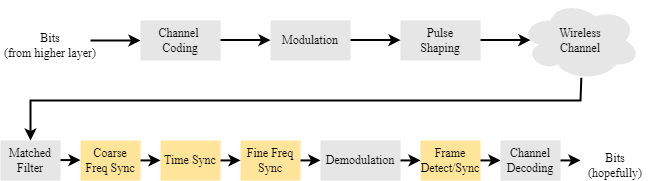

In [2211]:
from IPython.display import Image
Image(".\_images\wireless-channel.png")

# Generate bits
## Use Barker code as a preamble

In [2212]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

# this part came from pulse shaping exercise
num_symbols = 120
num_packets = 10
sps = 8 # Количество добавленных нулей
bits = np.array([])

for i in range(num_packets):
    bits = np.append(bits, [1,1,1,0,0,0,1,0,0,1,0]) # add preamble
    bits = np.append(bits, np.random.randint(0, 2, num_symbols))

#bits = np.random.randint(0, 2, num_symbols) # Our data to be transmitted, 1's and 0's
pulse_train = np.array([])
for bit in bits:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    pulse_train = np.concatenate((pulse_train, pulse)) # add the 8 samples to the signal

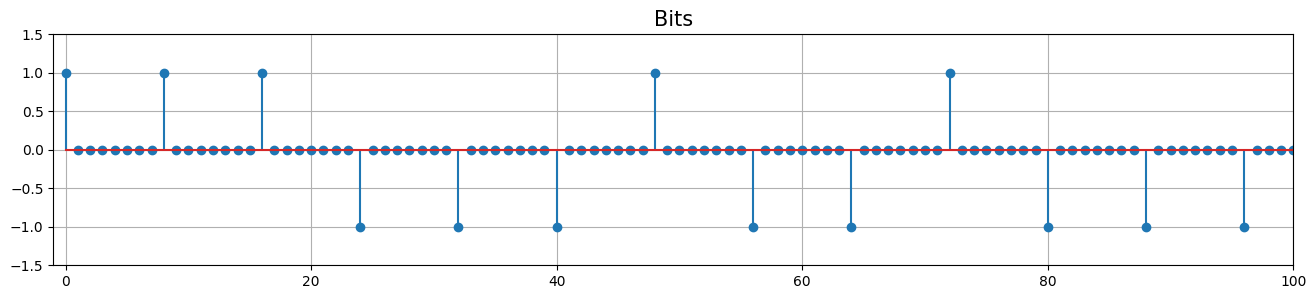

In [2213]:
# %matplotlib Qt5 - use Qt5 framework and create interactive window
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("Bits", fontsize=15)
ax.stem(pulse_train)
ax.set_xlim([-1, 100])
ax.set_ylim([-1.5, 1.5])
ax.grid(True)

# Create and apply raised-cosine filter

In [2214]:
# Create our raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(-51, 52) # remember it's not inclusive of final number
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

# Filter our signal, in order to apply the pulse shaping
samples = np.convolve(pulse_train, h)
samples_before = samples

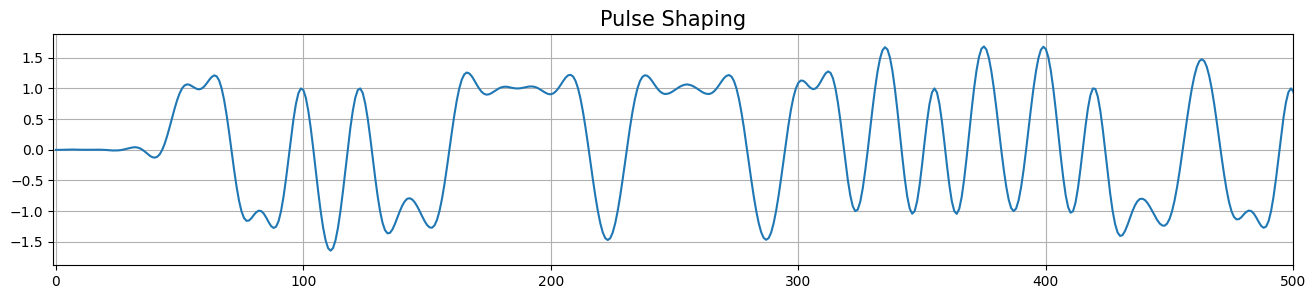

In [2215]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("Pulse Shaping", fontsize=15)
ax.plot(samples)
ax.set_xlim([-1, 500])
ax.grid(True)

In [2216]:
# Create and apply fractional delay filter
delay = 0.4 # fractional delay, in samples
N = 21 # number of taps
n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
h = np.sinc(n - delay) # calc filter taps
h *= np.hamming(N) # window the filter to make sure it decays to 0 on both sides
h /= np.sum(h) # normalize to get unity gain, we don't want to change the amplitude/power
samples = np.convolve(samples, h) # apply filter
samples_after = samples

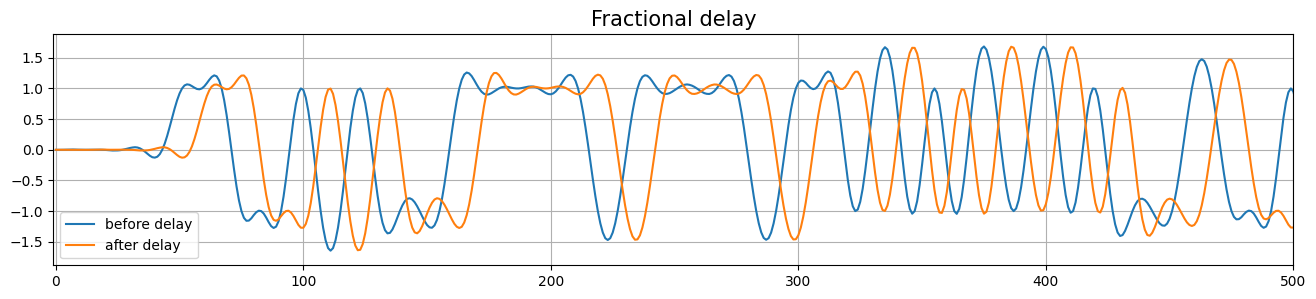

In [2217]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("Fractional delay", fontsize=15)

line1, = ax.plot(samples_before.real, label='before delay')
line2, = ax.plot(samples_after.real, label='after delay')
ax.set_xlim([-1, 500])
ax.legend()
ax.grid(True)

In [2218]:
# apply a freq offset
fs = 1e6 # assume our sample rate is 1 MHz
fo = 333 # simulate freq offset
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples), Ts) # create time vector
samples = samples * np.exp(1j*2*np.pi*fo*t) # perform freq shift
samples_for_iq = samples

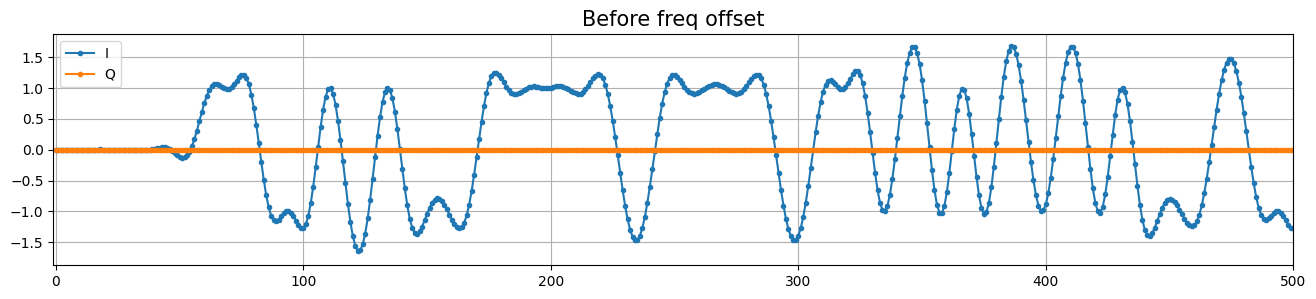

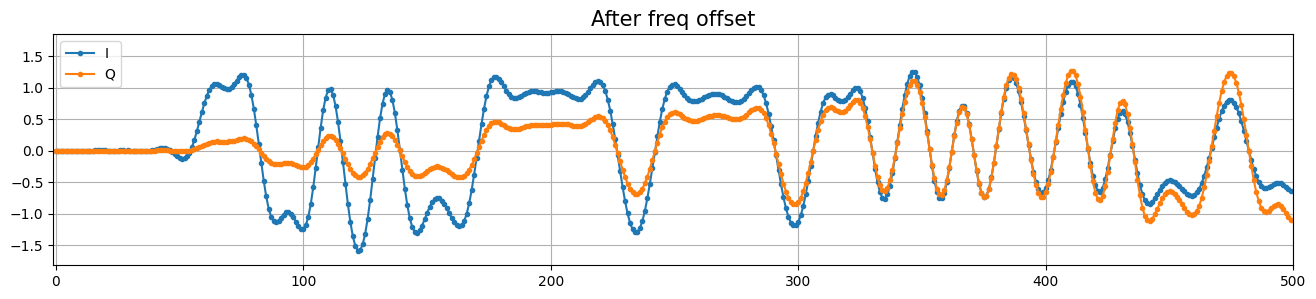

In [2219]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("Before freq offset", fontsize=15)
ax.plot(samples_after.real, '.-', label='I')
ax.plot(samples_after.imag, '.-', label='Q')
ax.legend()
ax.set_xlim([-1, 500])
ax.grid(True)

fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("After freq offset", fontsize=15)
ax.plot(samples.real, '.-', label='I')
ax.plot(samples.imag, '.-', label='Q')
ax.legend()
ax.set_xlim([-1, 500])
ax.grid(True)

## use the following equation for our coarse frequency sync

## $r^2(t) = s^2(t) e^{j4{\pi}f_{o}t}$

carrier offset = 707.4804263748811


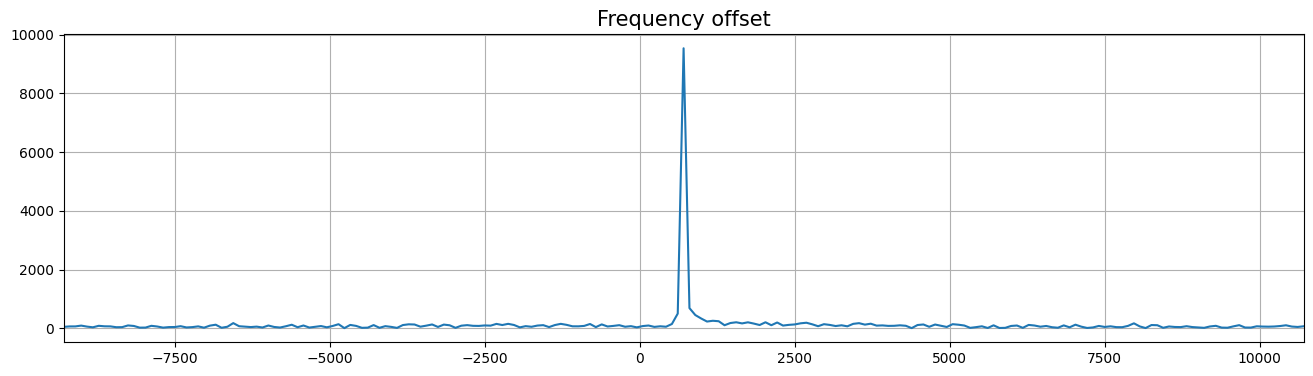

In [2220]:
# Add this before the FFT line
samples_pow = samples**2
psd = np.fft.fftshift(np.abs(np.fft.fft(samples_pow)))
f = np.linspace(-fs/2.0, fs/2.0, len(psd))
max_freq = f[np.argmax(psd)]
print("carrier offset =", max_freq)
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples), Ts) # create time vector
samples = samples * np.exp(-1j*2*np.pi*max_freq*t/2.0)

# Print frequency offset
fig, ax = plt.subplots(figsize=(16, 4))
ax.set_title("Frequency offset", fontsize=15)
ax.plot(f, psd)
ax.set_xlim([max_freq-10000, max_freq+10000])
ax.grid(True)

In [2221]:
samples_interpolated = signal.resample_poly(samples, 16, 1) # samples_interpolated

## Muller clock recovery

In [2222]:
mu = 0 # initial estimate of phase of sample
out = np.zeros(len(samples) + 10, dtype=complex)
out_rail = np.zeros(len(samples) + 10, dtype=complex) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(samples) and i_in+16 < len(samples):
    out[i_out] = samples_interpolated[i_in*16 + int(mu*16)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
samples = out # only include this line if you want to connect this code snippet with the Costas Loop later on

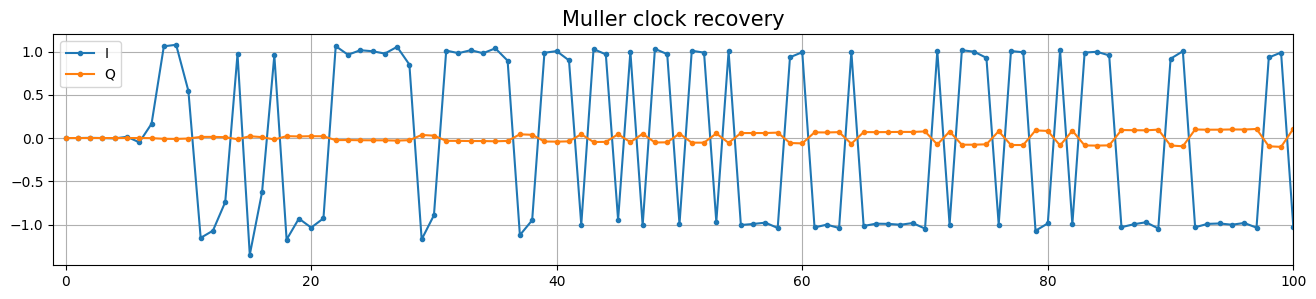

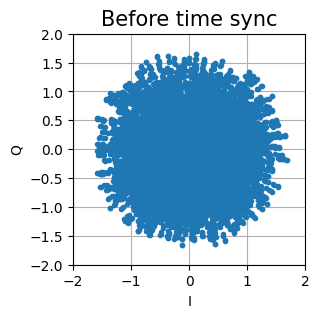

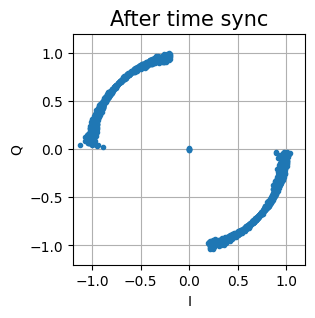

In [2223]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("Muller clock recovery", fontsize=15)
ax.plot(samples.real, '.-', label='I')
ax.plot(samples.imag, '.-', label='Q')
ax.legend()
ax.set_xlim([-1, 100])
ax.grid(True)

fig, ax = plt.subplots(figsize=(3, 3))
ax.set_title("Before time sync", fontsize=15)
ax.plot(samples_for_iq[30:].real, samples_for_iq[30:].imag, '.')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.grid(True)

fig, ax = plt.subplots(figsize=(3, 3))
ax.set_title("After time sync", fontsize=15)
ax.plot(samples[30:].real, samples[30:].imag, '.')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_xlabel('I')
ax.set_ylabel('Q')
ax.grid(True)

# Use Costas Loop for fine frequency synchronization

In [2224]:
N = len(samples)
phase = 0
freq = 0
# These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
loop_bw = 0.05  # This is what to adjust, to make the feedback loop faster or slower (which impacts stability)
damping = np.sqrt(2.0) / 2.0  # Set the damping factor for a critically damped system
alpha = (4 * damping * loop_bw) / (1.0 + (2.0 * damping * loop_bw) + loop_bw ** 2)
beta = (4 * loop_bw ** 2) / (1.0 + (2.0 * damping * loop_bw) + loop_bw ** 2)
out = np.zeros(N, dtype=complex)
freq_log = []
for i in range(N):
    out[i] = samples[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
    error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)

    # Advance the loop (recalc phase and freq offset)
    freq += (beta * error)
    freq_log.append(freq * fs / (2*np.pi)) # convert from angular velocity to Hz for logging
    phase += freq + (alpha * error)

    # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
    while phase >= 2*np.pi:
        phase -= 2*np.pi
    while phase < 0:
        phase += 2*np.pi

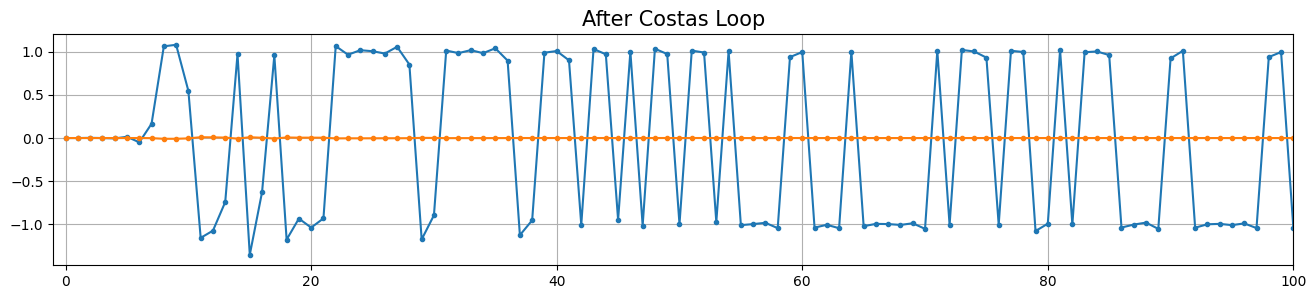

In [2225]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("After Costas Loop", fontsize=15)
ax.plot(out.real, '.-', label='I')
ax.plot(out.imag, '.-', label='Q')
ax.set_xlim([-1, 100])
ax.grid(True)

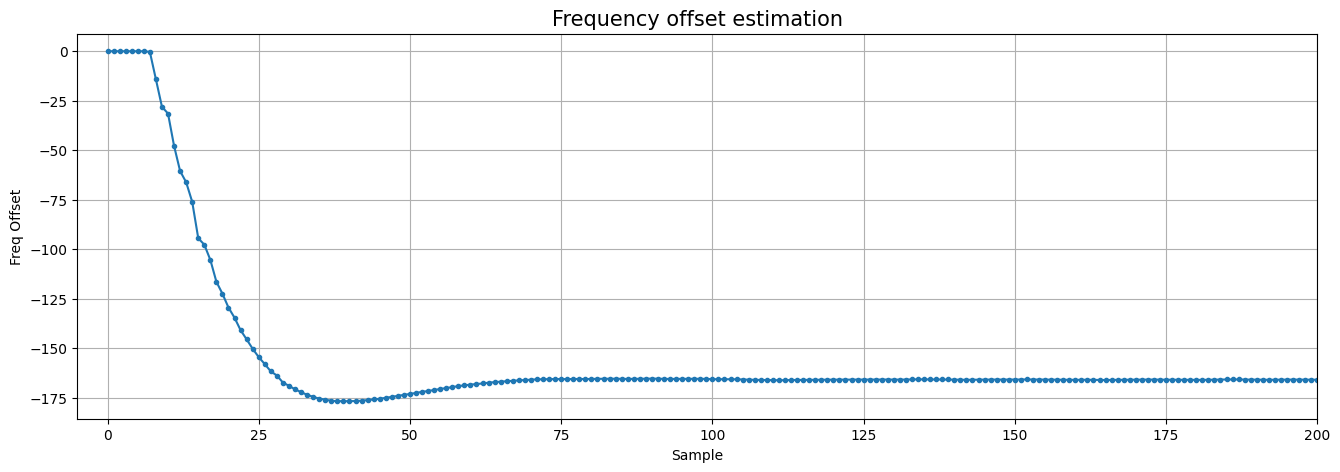

In [2226]:
# Plot freq over time to see how long it takes to hit the right offset
fig, ax = plt.subplots(figsize=(16, 5))
ax.set_title("Frequency offset estimation", fontsize=15)
ax.plot(freq_log, '.-')
ax.set_xlabel('Sample')
ax.set_ylabel('Freq Offset')
ax.set_xlim([-5, 200])
ax.grid(True)

index 8
index 139
index 270
index 401
index 532
index 663
index 794
index 925
index 1056
index 1187

find packets	 10
lenght sequence	 1324


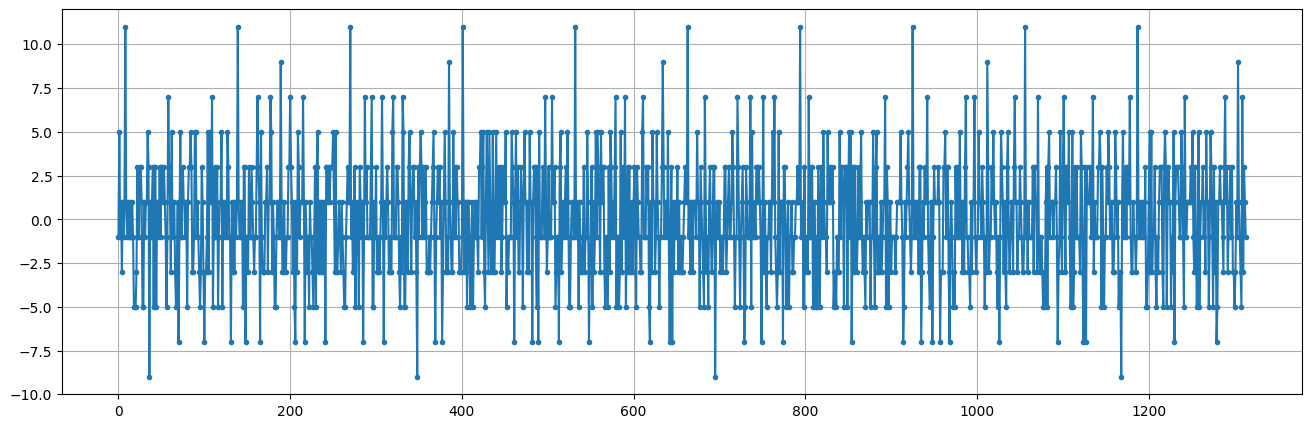

In [2227]:
preamble = [1,1,1,-1,-1,-1,1,-1,-1,1,-1]

# demodulation
sequence = out.real
for i in range(len(sequence)):
    if sequence[i] < 0:
        sequence[i] = int(-1)
    else:
        sequence[i] = int(1)

# Frame Detect
matched = np.correlate(sequence, preamble,'valid')

count_match = 0
for i in range(len(matched)):
    if matched[i] > 10:
        print(f"index {i}")
        count_match += 1
print(f"\nfind packets\t {count_match}")
print(f"lenght sequence\t {len(sequence)}")

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(matched, '.-')
#ax.set_xlim([-5, 200])
ax.grid()